# Problem Statement: To build deep learning model to classify X-Ray image has viral pheumonia(i.e COVID) or not.
## Objective: The main purpose of this project is to build a CNN model using pretrained model and functional API, that would classify if subject has a COVID or not base on X-RAY. We will also try to map the class activation function using GRAD-CAM.

![](download.jpg)

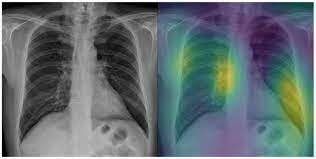

In [2]:
from IPython.display import display,Image

img=Image(filename='Downloads/download.jpg')

display(img)

### Dataset overview: We have two groups of X-RAY images, one that represents COVID positive X-Ray images and the other that has healthy chest X-Ray images.¶

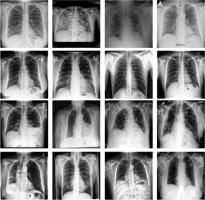

In [3]:
from IPython.display import display,Image

img=Image(filename='Desktop/1-s2.0-S1361841520301584-fx1.jpg')

display(img)

In [4]:
# to ignore the warnings 
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import numpy as np
import os
import shutil
import glob
import matplotlib.pyplot as plt 

### Going through metadata

In [6]:
#Covid 19 - X-Ray
covid_imgs = pd.read_excel("Desktop/COVID-19_Radiography_Dataset/COVID.metadata.xlsx")
covid_imgs.head(2)

,FILE NAME,FORMAT,SIZE,URL
0,COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
1,COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covi...


In [7]:
#Non-COVID lung infection
opacity_images = pd.read_excel("Desktop/COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx")
opacity_images.head(2)

,FILE NAME,FORMAT,SIZE,URL
0,Lung_Opacity-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,Lung_Opacity-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [33]:
ROOT_DIR = "Desktop/COVID-19_Radiography_Dataset/"
imgs = ['COVID','Lung_Opacity','Normal','Viral Pneumonia']

NEW_DIR = "Desktop/all_images/"

In [34]:
# Copy all my images to a new folder i.e NEW_DIR

if not os.path.exists(NEW_DIR):
  os.mkdir(NEW_DIR)

  for i in imgs:
    org_dir = os.path.join(ROOT_DIR, i+"/")
    
    for imgfile in glob.iglob(os.path.join(org_dir, "*.png")):
      shutil.copy(imgfile, NEW_DIR)
      
else:
  print("Already Exist")

### Let's visualize number of images in each categoris

In [35]:
counter = {'COVID':0,'Lung_Opacity':0,'Normal':0,'Viral Pneumonia':0}

for image in imgs:
  for count in glob.iglob(NEW_DIR+image+"*"):
    counter[image] += 1

counter

{'COVID': 3616, 'Lung_Opacity': 6012, 'Normal': 10192, 'Viral Pneumonia': 1345}

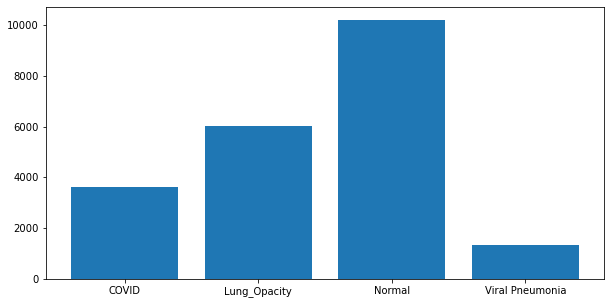

In [36]:
plt.figure(figsize=(10,5))
plt.bar(x = counter.keys(), height= counter.values())
plt.show()

## First of all we need to give equal amout of data for every class. 
## we will be Deviding our data between Train, Test, Validation

### Train Data: 
        Normal : 3500
        Lung Opacity : 3500 
        Covid+ Pneumonia : 3000 + 500

### Validation Data:
        Normal : 1000
        Lung Opacity : 1000
        Covid + Pneumonia : 500 +500

### Test Data:
        Normal : 1000
        Lung Opacity : 1000
        Covid + Pneumonia : 100 +500

## We will be ignoring the lung opacity as its not related to our problem statement.

In [37]:
#Creating the folder

if not os.path.exists(NEW_DIR+"train_test_split/"):

  os.makedirs(NEW_DIR+"train_test_split/")

  os.makedirs(NEW_DIR+"train_test_split/train/Normal")
  os.makedirs(NEW_DIR+"train_test_split/train/Covid")

  os.makedirs(NEW_DIR+"train_test_split/test/Normal")
  os.makedirs(NEW_DIR+"train_test_split/test/Covid")

  os.makedirs(NEW_DIR+"train_test_split/validation/Normal")
  os.makedirs(NEW_DIR+"train_test_split/validation/Covid")


  # Train Data
  for i in np.random.choice(replace= False , size= 3000 , a = glob.glob(NEW_DIR+imgs[0]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/train/Covid" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 3900 , a = glob.glob(NEW_DIR+imgs[2]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/train/Normal" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 900 , a = glob.glob(NEW_DIR+imgs[3]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/train/Covid" )
    os.remove(i)

  # Validation Data
  for i in np.random.choice(replace= False , size= 308 , a = glob.glob(NEW_DIR+imgs[0]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/validation/Covid" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 500 , a = glob.glob(NEW_DIR+imgs[2]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/validation/Normal" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 200 , a = glob.glob(NEW_DIR+imgs[3]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/validation/Covid" )
    os.remove(i)

  # Test Data
  for i in np.random.choice(replace= False , size= 300 , a = glob.glob(NEW_DIR+imgs[0]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/test/Covid" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 300 , a = glob.glob(NEW_DIR+imgs[2]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/test/Normal" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 200 , a = glob.glob(NEW_DIR+imgs[3]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/test/Covid" )
    os.remove(i)

In [41]:
train_path  = "Desktop/all_images/train_test_split/train"
valid_path  = "Desktop/all_images/train_test_split/validation"
test_path   = "Desktop/all_images/train_test_split/test"

In [42]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import vgg16
from keras.models import Model
from keras.layers import Dense, MaxPool2D, Conv2D
import keras

In [43]:
train_data_gen = ImageDataGenerator(preprocessing_function= vgg16.preprocess_input , zoom_range= 0.2, horizontal_flip= True, shear_range= 0.2 , rescale= 1./255)
train = train_data_gen.flow_from_directory(directory= train_path , target_size=(224,224))

Found 7800 images belonging to 2 classes.


In [44]:
validation_data_gen = ImageDataGenerator(preprocessing_function= vgg16.preprocess_input , rescale= 1./255 )
valid = validation_data_gen.flow_from_directory(directory= valid_path , target_size=(224,224))

Found 1008 images belonging to 2 classes.


In [45]:
test_data_gen = ImageDataGenerator(preprocessing_function= vgg16.preprocess_input, rescale= 1./255 )
test = train_data_gen.flow_from_directory(directory= test_path , target_size=(224,224), shuffle= False)

Found 800 images belonging to 2 classes.


In [46]:
train.class_indices

{'Covid': 0, 'Normal': 1}

In [50]:
class_type = {0:'Covid',  1 : 'Normal'}

In [51]:
t_img , label = train.next()

In [52]:
t_img.shape,label.shape

((32, 224, 224, 3), (32, 2))

In [53]:
label[0]

array([1., 0.], dtype=float32)

In [58]:
def plotImages(img_arr, label):

  for im, l in zip(img_arr,label) :
    plt.figure(figsize= (5,5))
    plt.imshow(im, cmap = 'gray')
    plt.title(im.shape)
    plt.axis = False
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


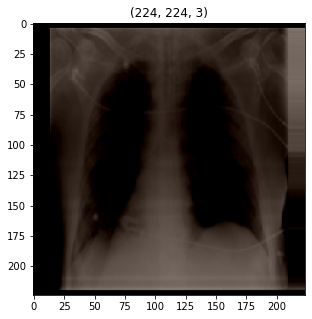

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


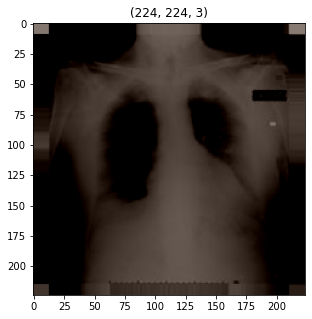

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


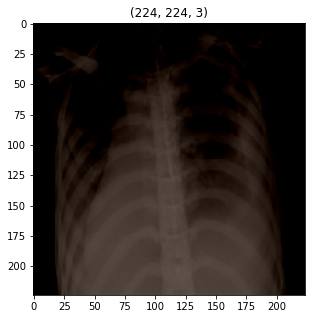

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


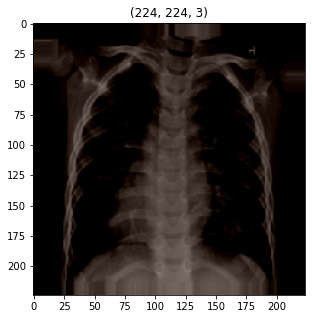

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


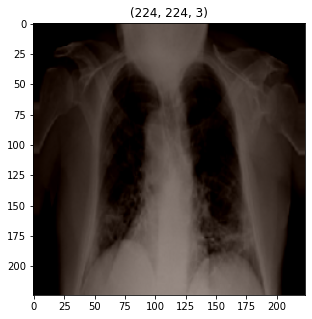

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


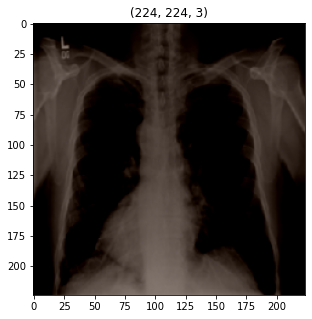

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


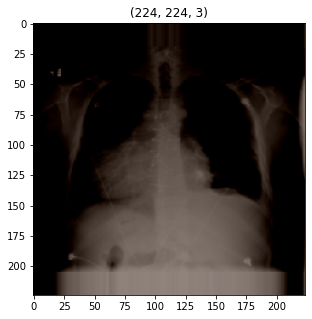

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


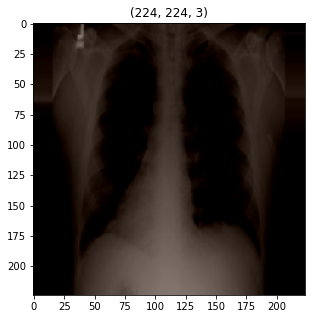

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


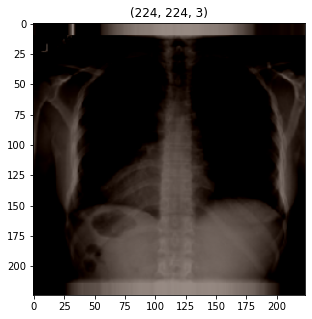

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


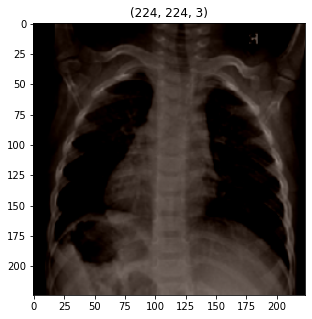

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


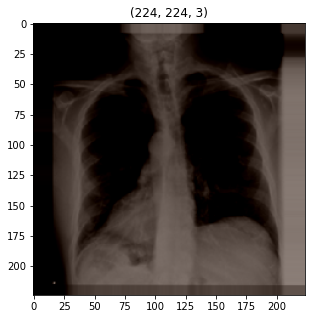

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


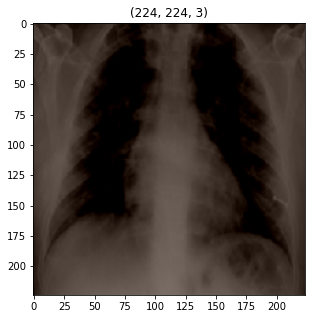

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


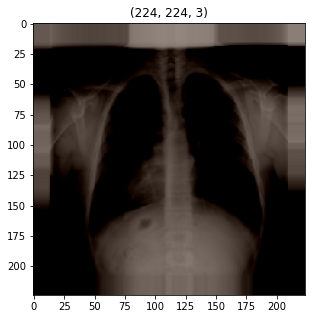

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


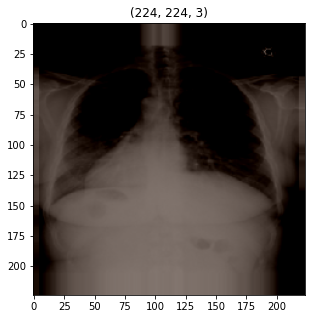

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


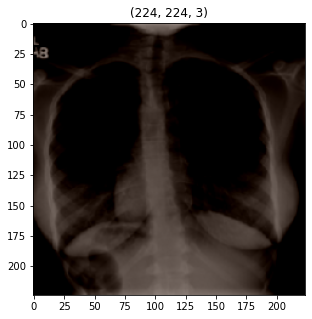

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


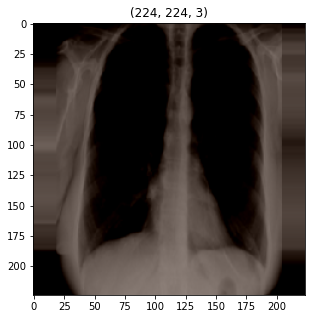

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


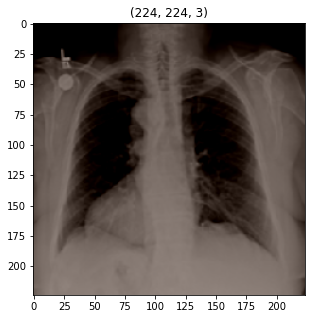

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


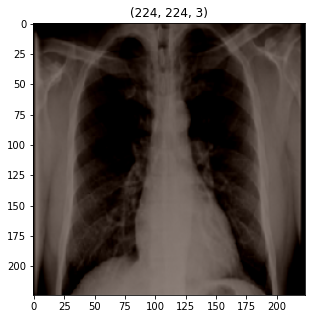

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


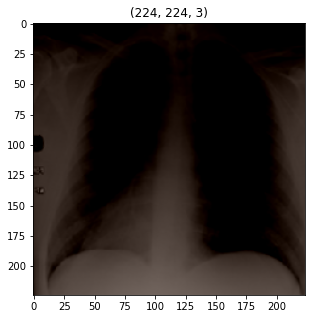

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


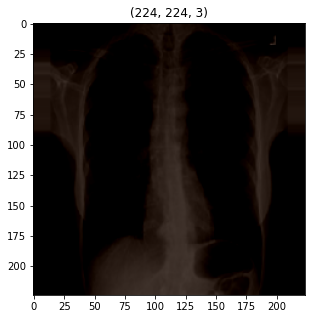

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


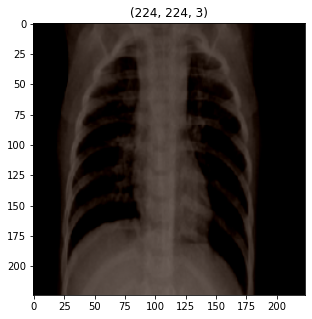

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


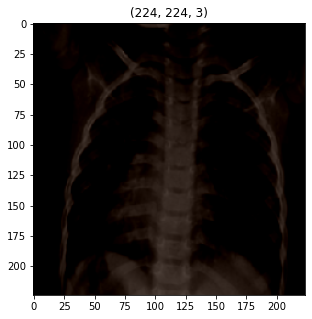

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


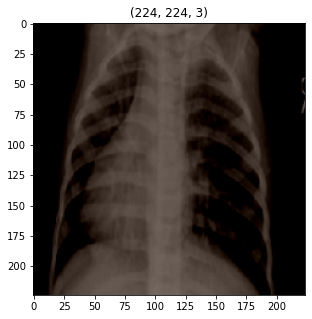

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


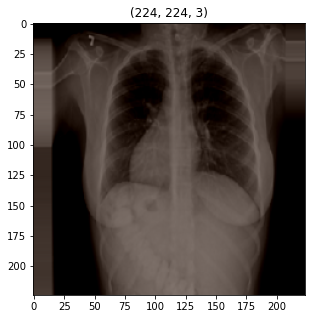

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


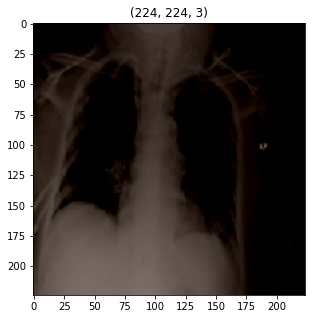

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


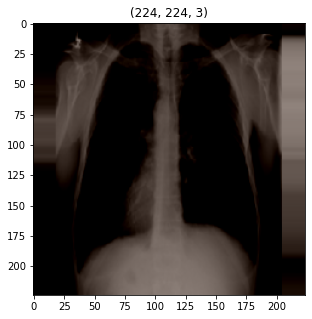

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


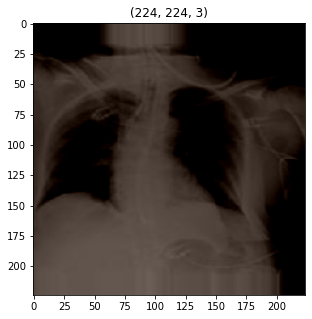

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


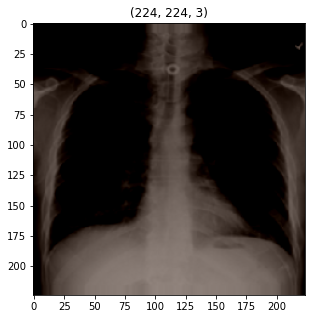

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


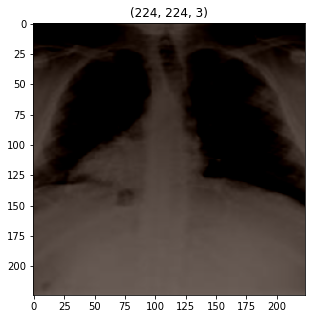

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


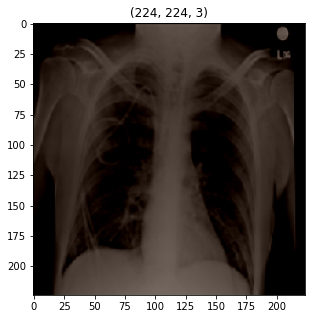

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


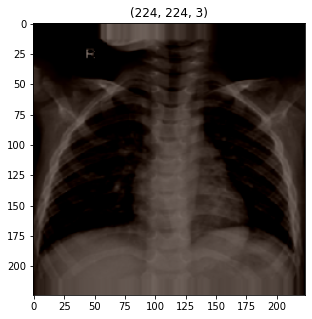

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


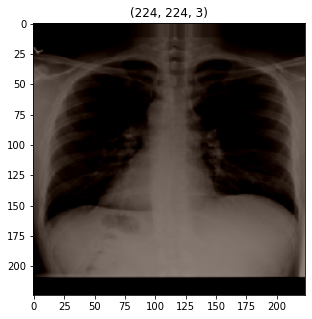

In [59]:
plotImages(t_img, label)

# Model Arechitecture: VGGNet
## VGGNet is a convolution neural net (CNN ) architecture which was used to win ILSVR(Imagenet) competition in 2014. It is considered to be one of the excellent vision model architecture till date. ... It follows this arrangement of convolution and max pool layers consistently throughout the whole architecture.


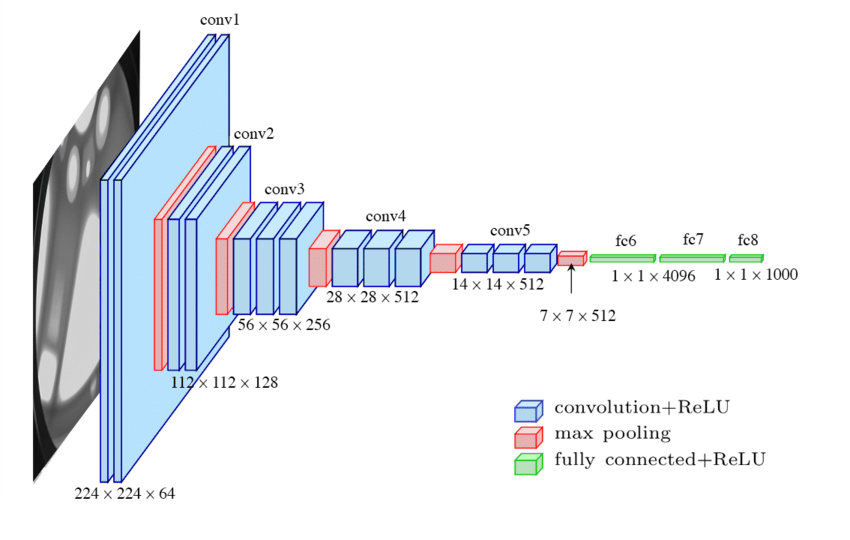

In [60]:
from IPython.display import display,Image

img=Image(filename='Desktop/Fig-A1-The-standard-VGG-16-network-architecture-as-proposed-in-32-Note-that-only.png')

display(img)

In [61]:
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten , Dense, Dropout , MaxPool2D

In [62]:
vgg = VGG16( input_shape=(224,224,3), include_top= False) # include_top will consider the new weight

58900480/58889256 [==============================] - 49s 1us/step


In [63]:
for layer in vgg.layers:           # Dont Train the parameters again 
  layer.trainable = False

In [64]:
x = Flatten()(vgg.output)
x = Dense(units=2 , activation='sigmoid', name = 'predictions' )(x)

model = Model(vgg.input, x)

In [65]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [66]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [67]:
# implementing early stopping and model check point 

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor= "val_accuracy" , min_delta= 0.01, patience= 3, verbose=1)
mc = ModelCheckpoint(filepath="bestmodel.h5", monitor="val_accuracy", verbose=1, save_best_only= True)

In [68]:
#hist = model.fit_generator(train, steps_per_epoch= 10, epochs= 8, validation_data= valid , validation_steps= 32)
hist = model.fit_generator(train, steps_per_epoch= 10, epochs= 30, validation_data= valid , validation_steps= 32, callbacks=[es,mc])

Epoch 1/30
10/10 [==============================] - 159s 17s/step - loss: 1.4467 - accuracy: 0.4625 - val_loss: 1.1674 - val_accuracy: 0.5040

Epoch 00001: val_accuracy improved from -inf to 0.50397, saving model to bestmodel.h5
Epoch 2/30
10/10 [==============================] - 157s 17s/step - loss: 0.6935 - accuracy: 0.7063 - val_loss: 0.4219 - val_accuracy: 0.8016

Epoch 00002: val_accuracy improved from 0.50397 to 0.80159, saving model to bestmodel.h5
Epoch 3/30
10/10 [==============================] - 158s 17s/step - loss: 0.6087 - accuracy: 0.7344 - val_loss: 0.3990 - val_accuracy: 0.8105

Epoch 00003: val_accuracy improved from 0.80159 to 0.81052, saving model to bestmodel.h5
Epoch 4/30
10/10 [==============================] - 159s 17s/step - loss: 0.4545 - accuracy: 0.8250 - val_loss: 0.3741 - val_accuracy: 0.8175

Epoch 00004: val_accuracy improved from 0.81052 to 0.81746, saving model to bestmodel.h5
Epoch 5/30
10/10 [==============================] - 159s 17s/step - loss: 0

In [70]:
## load only the best model 
from keras.models import load_model
model = load_model("bestmodel.h5")

# Check the performance of the model

In [71]:
h = hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

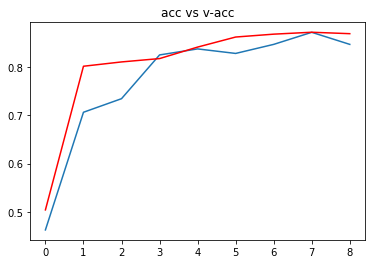

In [72]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

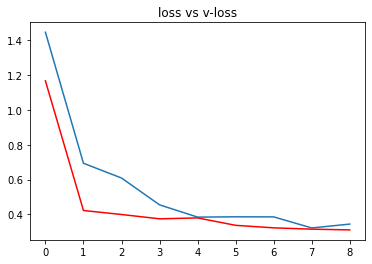

In [73]:
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

In [74]:
# checking out the accurscy of our model 

acc = model.evaluate_generator(generator= test)[1] 

print(f"The accuracy of your model is = {acc} %")

The accuracy of your model is = 0.875 %


In [75]:
from keras.preprocessing import image

def get_img_array(img_path):
  """
  Input : Takes in image path as input 
  Output : Gives out Pre-Processed image
  """
  path = img_path
  img = image.load_img(path, target_size=(224,224,3))
  img = image.img_to_array(img)/255
  img = np.expand_dims(img , axis= 0 )
  
  return img

The given X-Ray image is of type = Covid

The chances of image being Covid is : 78.61288785934448 percent

The chances of image being Normal is : 24.449095129966736 percent


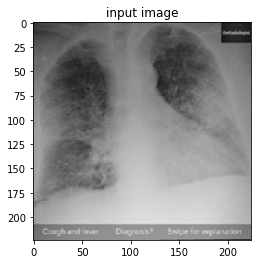

In [78]:
# path for that new image. ( you can take it either from google or any other scource)

path = "Desktop/COVID-19_Radiography_Dataset/COVID/COVID-1008.png"       # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = class_type[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")

# to display the image  
plt.imshow(img[0], cmap = "gray")
plt.title("input image")
plt.show()

## GRAD-CAM Visualization

In [79]:
import tensorflow as tf

In [80]:
# this function is udes to generate the heat map of aan image


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [81]:
import matplotlib.cm as cm

from IPython.display import Image, display

In [82]:
# put the heatmap to our image to understand the area of interest

def save_and_display_gradcam(img_path , heatmap, cam_path="cam.jpg", alpha=0.4):
    """
    img input shoud not be expanded 
    """

    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


In [83]:
# function that is used to predict the image type and the ares that are affected by covid


def image_prediction_and_visualization(path,last_conv_layer_name = "block5_conv3", model = model):
  """
  input:  is the image path, name of last convolution layer , model name
  output : returs the predictions and the area that is effected
  """
  
  
  
  img_array = get_img_array(path)

  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

  img = get_img_array(path)

  res = class_type[np.argmax(model.predict(img))]
  print(f"The given X-Ray image is of type = {res}")
  print()
  print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} %")
  print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} %")

  print()
  print("image with heatmap representing the covid spot")

  # function call
  save_and_display_gradcam(path, heatmap)

  print()
  print("the original input image")
  print()

  a = plt.imread(path)
  plt.imshow(a, cmap = "gray")
  plt.title("Original image")
  plt.show()

The given X-Ray image is of type = Covid

The chances of image being Covid is : 78.61288785934448 %
The chances of image being Normal is : 24.449095129966736 %

image with heatmap representing the covid spot


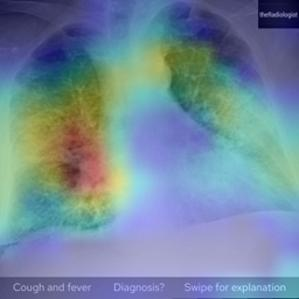


the original input image



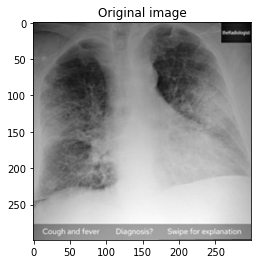

In [85]:
#predictions
# provide the path of any image from google or any other scource 
# the path is already defigned above , but you can also provide the path here to avoid scrolling up 

# for covid image : 
path = "Desktop/COVID-19_Radiography_Dataset/COVID/COVID-1008.png"

image_prediction_and_visualization(path)

The given X-Ray image is of type = Normal

The chances of image being Covid is : 11.460396647453308 %
The chances of image being Normal is : 89.1893744468689 %

image with heatmap representing the covid spot


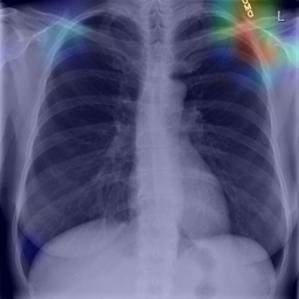


the original input image



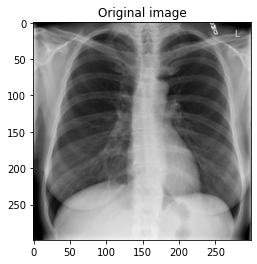

In [86]:
# for normal image : 
path = "Desktop/COVID-19_Radiography_Dataset/Normal/Normal-10008.png"

image_prediction_and_visualization(path)

# Result: